###### About Alzheimer’s Disease: 
Alzheimer’s is a progressive disease, where dementia symptoms gradually worsen over a number of years. In its early stages, memory loss is mild, but with late-stage Alzheimer’s, individuals lose the ability to carry on a conversation and respond to their environment.
Although current Alzheimer’s treatments cannot stop Alzheimer’s from progressing, they can temporarily slow the worsening of dementia symptoms and improve quality of life for those with Alzheimer’s and their caregivers. Image Processing plays an important role in the early detection of Alzheimer’s disease so that patients can be prevented before irreversible changes occur in the brain.


Alzheimer’s Dataset :
https://www.kaggle.com/yasserhessein/dataset-alzheimer



Prediction model for Classifying the **four types** of **Alzheimer's Disease**

**Four types** of **Alzheimer's Disease** : 
- Mild Demented
- Moderate Demented
- Non Demented
- Very Mild Demented

#### Importing required libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 

In [2]:
import tensorflow as tf
tf.__version__

'2.6.0'

In [6]:
from tensorflow import keras
from tensorflow.keras import layers
from keras.preprocessing import image
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications.resnet_v2 import ResNet152V2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D

##### Loading the data as train set and validation set

In [4]:
# Data Generator
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1./255., # rescaling
                                   rotation_range = 40,  # for augmentation
                                   width_shift_range = 0.2,
                                   validation_split = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1.0/255.,validation_split = 0.2)

test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1.0/255.)

train_ds = train_datagen.flow_from_directory('train',
                                                    batch_size = 32,
                                                    subset="training",
                                                    class_mode = 'categorical', 
                                                    target_size = (256, 256))

val_ds = val_datagen.flow_from_directory('test',
                                                subset = "validation",
                                                    batch_size = 32,
                                                    class_mode = 'categorical', 
                                                    target_size = (256, 256))

Found 4098 images belonging to 4 classes.
Found 254 images belonging to 4 classes.


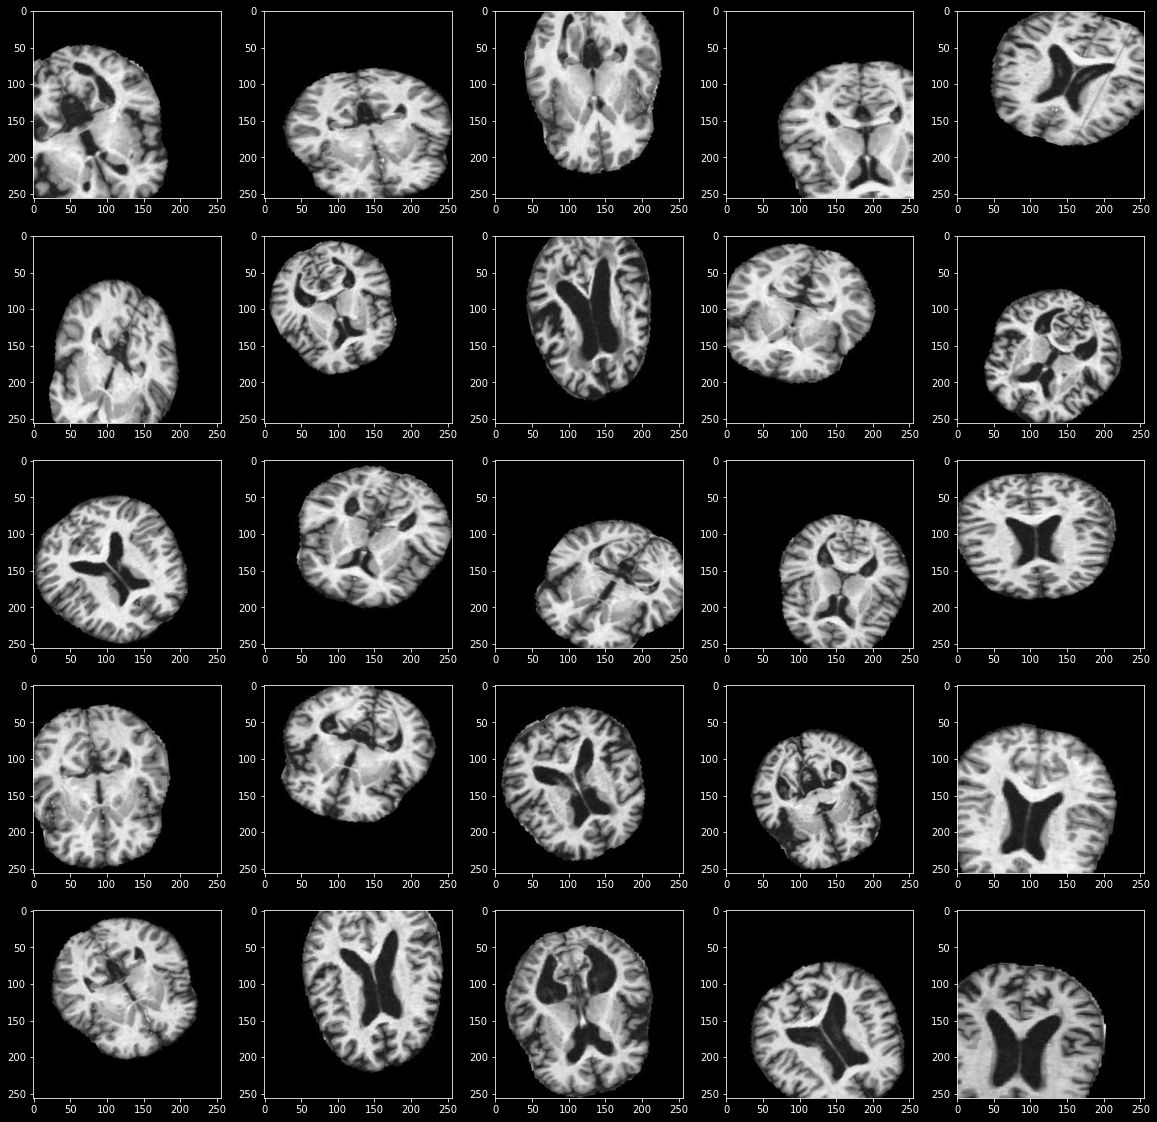

In [101]:
# Visualize Train Images
image , label = next(iter(train_ds))
plt.figure(figsize=(20,20))
for i in range(25):
    ax = plt.subplot(5,5, i+1)
    plt.imshow(image[i].reshape(256 , 256 , 3))

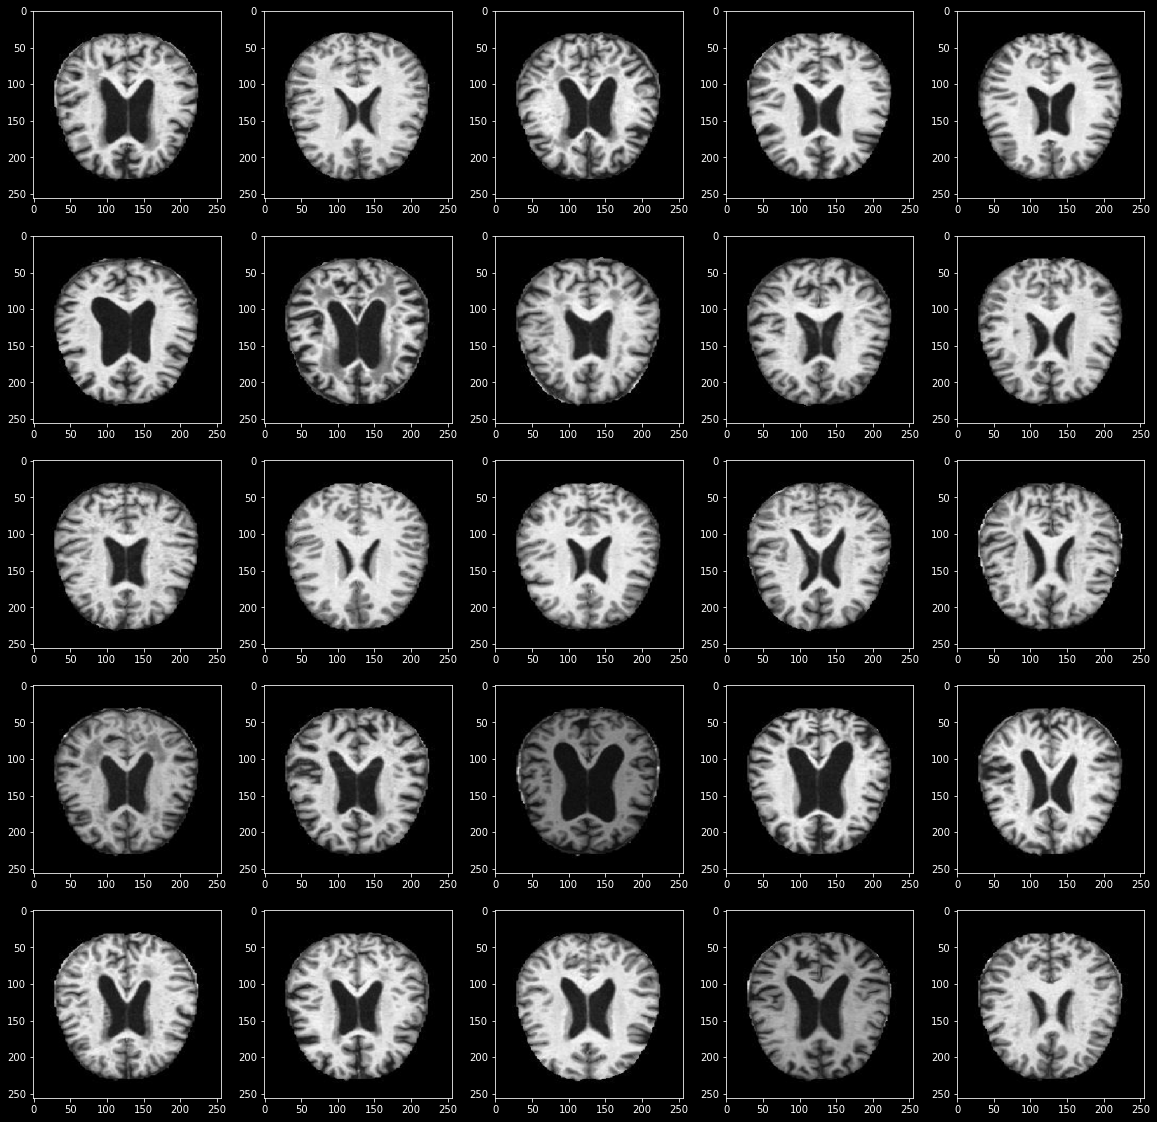

In [103]:
# Visualize Test Images
image , label = next(iter(val_ds))
plt.figure(figsize=(20,20))
for i in range(25):
    ax = plt.subplot(5,5, i+1)
    plt.imshow(image[i].reshape(256 , 256 , 3))

In [45]:
train_ds[128]

(array([[[[0.39812523, 0.39812523, 0.39812523],
          [0.39853054, 0.39853054, 0.39853054],
          [0.45011166, 0.45011166, 0.45011166],
          ...,
          [0.        , 0.        , 0.        ],
          [0.        , 0.        , 0.        ],
          [0.        , 0.        , 0.        ]],
 
         [[0.3898926 , 0.3898926 , 0.3898926 ],
          [0.40991792, 0.40991792, 0.40991792],
          [0.43137258, 0.43137258, 0.43137258],
          ...,
          [0.        , 0.        , 0.        ],
          [0.        , 0.        , 0.        ],
          [0.        , 0.        , 0.        ]],
 
         [[0.40667847, 0.40667847, 0.40667847],
          [0.44227138, 0.44227138, 0.44227138],
          [0.440977  , 0.440977  , 0.440977  ],
          ...,
          [0.        , 0.        , 0.        ],
          [0.        , 0.        , 0.        ],
          [0.        , 0.        , 0.        ]],
 
         ...,
 
         [[0.        , 0.        , 0.        ],
          [0.     

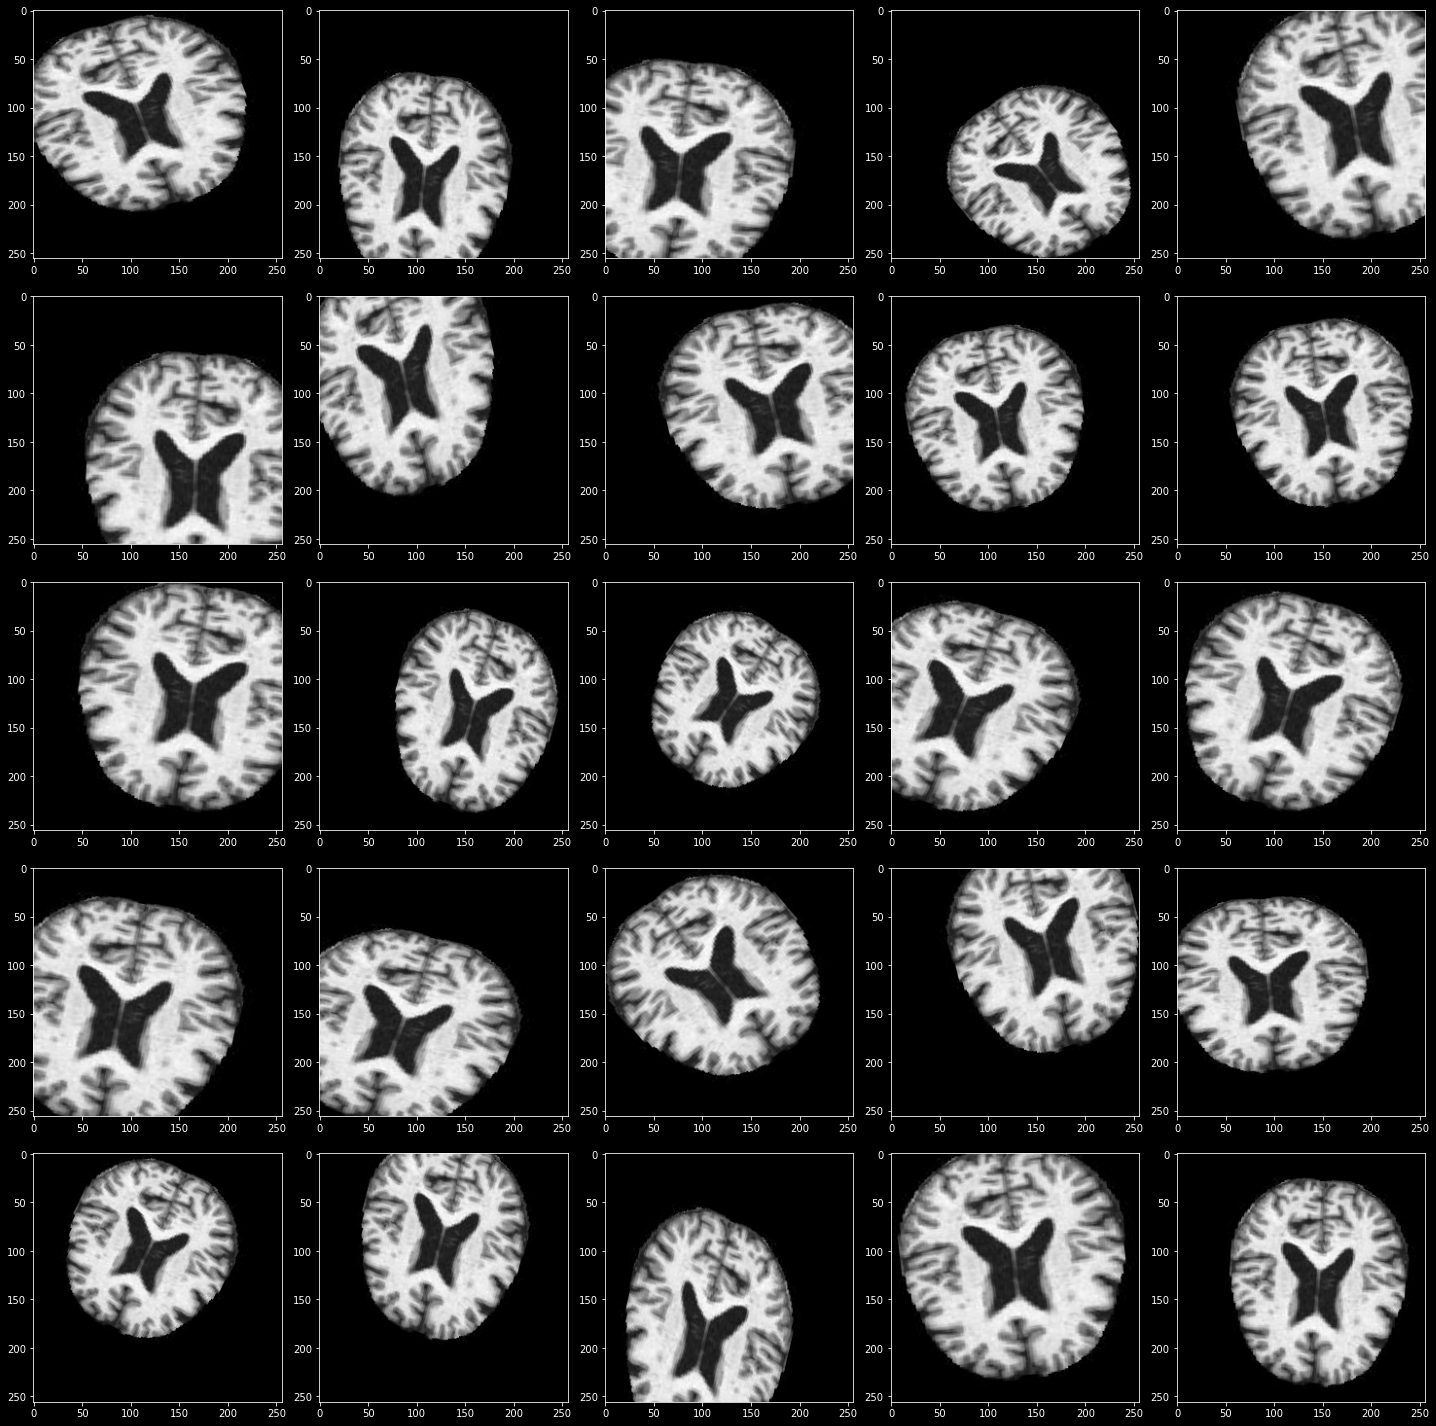

In [105]:
# Plot processed train images
def plotImages(images_arr):
    fig, axes = plt.subplots(5, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()
    
    
augmented_images = [train_ds[0][0][0] for i in range(25)]
plotImages(augmented_images)

In [64]:
# create optimizer object
optimizer = tf.keras.optimizers.Nadam(learning_rate=0.001, beta_1=0.9,                                           beta_2=0.999)

# take pretrained model
model = ResNet152V2(include_top=False, input_shape=(256, 256, 3))
# another option to use input shape as (128,128,3)

# freeze the all pretrained model layers
for layer in model.layers:
    layer.trainable = False

    # this will un-freeze the pretrained model's normalized layers.
    # pretty slow process but works fine with heavy number of classes
    # if "BatchNormalization" in layer.__class__.__name__:
    #     layer.trainable = True

dropout = Dropout(0.1)(model.layers[-1].output)


# BatchNormalization for the output of the pretrained model
batch = BatchNormalization()(dropout)

# GlobalAveragePooling2D works better with ResNet152V2
pool = GlobalAveragePooling2D(name="avg_pool")(batch)
flat = Flatten()(pool)

dense = Dense(128, activation="relu", kernel_initializer="he_uniform")(flat)
dropout = Dropout(0.05)(dense)

dense = Dense(64)(dropout)
dropout = Dropout(0.05)(dense)

dense = Dense(48)(dropout)
dropout = Dropout(0.05)(dense)

dense = Dense(36)(dropout)
dropout = Dropout(0.05)(dense)

dense = Dense(24)(dropout)
dense = Dense(12)(dense)
output = Dense(4, activation="softmax")(dense)

model = Model(inputs=model.inputs, outputs=output)
# compile model
model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics="accuracy")
# initiate early stoping
es = EarlyStopping(monitor="val_accuracy", min_delta=0.005, verbose=1, patience=3, restore_best_weights=True)
# train model
history = model.fit(train_ds, validation_data=val_ds,epochs= 20, steps_per_epoch=len(train_ds), callbacks=[es])



Epoch 1/20
129/129 [==============================] - 90s 645ms/step - loss: 0.9454 - accuracy: 0.5488 - val_loss: 0.9530 - val_accuracy: 0.5748
Epoch 2/20
129/129 [==============================] - 80s 614ms/step - loss: 0.8646 - accuracy: 0.5976 - val_loss: 0.9382 - val_accuracy: 0.5669
Epoch 3/20
129/129 [==============================] - 80s 617ms/step - loss: 0.8424 - accuracy: 0.6025 - val_loss: 0.8456 - val_accuracy: 0.6260
Epoch 4/20
129/129 [==============================] - 79s 610ms/step - loss: 0.8068 - accuracy: 0.6271 - val_loss: 0.8408 - val_accuracy: 0.6378
Epoch 5/20
129/129 [==============================] - 77s 598ms/step - loss: 0.7914 - accuracy: 0.6388 - val_loss: 0.8709 - val_accuracy: 0.6260
Epoch 6/20
129/129 [==============================] - 78s 605ms/step - loss: 0.7661 - accuracy: 0.6581 - val_loss: 0.8360 - val_accuracy: 0.6181
Epoch 7/20
129/129 [==============================] - 78s 604ms/step - loss: 0.7649 - accuracy: 0.6528 - val_loss: 0.8460 - val_ac

In [70]:
optimizer = tf.keras.optimizers.Adamax(learning_rate=0.001, beta_1=0.9,                                           beta_2=0.999)
model = ResNet152V2(include_top=False, input_shape=(256, 256, 3))
# another option to use input shape as (128,128,3)

# freeze the all pretrained model layers
for layer in model.layers:
    layer.trainable = False

    # this will un-freeze the pretrained model's normalized layers.
    # pretty slow process but works fine with heavy number of classes
    # if "BatchNormalization" in layer.__class__.__name__:
    #     layer.trainable = True

dropout = Dropout(0.1)(model.layers[-1].output)


# BatchNormalization for the output of the pretrained model
batch = BatchNormalization()(dropout)

# GlobalAveragePooling2D works better with ResNet152V2
pool = GlobalAveragePooling2D(name="avg_pool")(batch)
flat = Flatten()(pool)

dense = Dense(128, activation="relu", kernel_initializer="he_uniform")(flat)
dropout = Dropout(0.05)(dense)

dense = Dense(64)(dropout)
dropout = Dropout(0.05)(dense)

dense = Dense(48)(dropout)
dropout = Dropout(0.05)(dense)

dense = Dense(36)(dropout)
dropout = Dropout(0.05)(dense)

dense = Dense(24)(dropout)
dense = Dense(12)(dense)
output = Dense(4, activation="softmax")(dense)

model = Model(inputs=model.inputs, outputs=output)
model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics="accuracy")
es = EarlyStopping(monitor="val_loss", min_delta=0.005, verbose=1, patience=3, restore_best_weights=True)
history = model.fit(train_ds, validation_data=val_ds,epochs= 20, steps_per_epoch=len(train_ds), callbacks=[es])


Epoch 1/20
129/129 [==============================] - 88s 627ms/step - loss: 0.9428 - accuracy: 0.5456 - val_loss: 0.9762 - val_accuracy: 0.5236
Epoch 2/20
129/129 [==============================] - 80s 616ms/step - loss: 0.8782 - accuracy: 0.5874 - val_loss: 0.9442 - val_accuracy: 0.5787
Epoch 3/20
129/129 [==============================] - 79s 613ms/step - loss: 0.8520 - accuracy: 0.6008 - val_loss: 0.9457 - val_accuracy: 0.5354
Epoch 4/20
129/129 [==============================] - 79s 613ms/step - loss: 0.8239 - accuracy: 0.6144 - val_loss: 0.9483 - val_accuracy: 0.5512
Epoch 5/20
129/129 [==============================] - 79s 612ms/step - loss: 0.8166 - accuracy: 0.6213 - val_loss: 0.8997 - val_accuracy: 0.5748
Epoch 6/20
129/129 [==============================] - 79s 613ms/step - loss: 0.8052 - accuracy: 0.6362 - val_loss: 0.8668 - val_accuracy: 0.5787
Epoch 7/20
129/129 [==============================] - 79s 612ms/step - loss: 0.7915 - accuracy: 0.6320 - val_loss: 0.8417 - val_ac

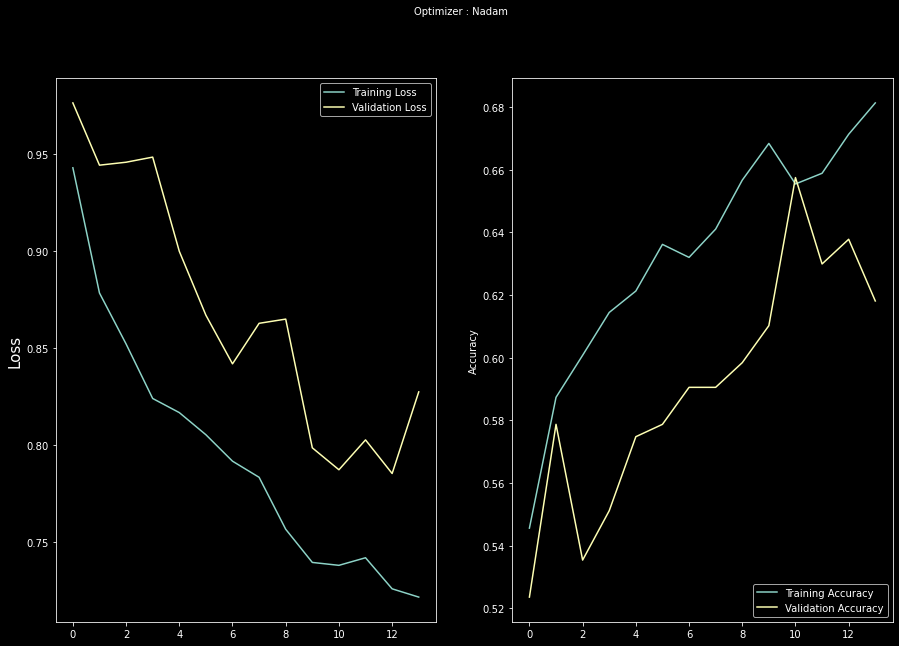

In [71]:
#### Plot the result on validation data

plt.figure(figsize=(15,10))
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : Nadam', fontsize=10)
plt.ylabel('Loss', fontsize=15)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=10)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()